In [203]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

In [204]:
iris = load_iris()

In [205]:
class NeuralNetwork:

  # the weights are a matrix (can be seen as nested lists)
  # the first dimension is the amount of nodes in the previous layer
  # the second dimension is the amount of nodes in the next layer
  # the bias is a vector (like a single list) of zeros, which will be updated during backpropagation
  def __init__(self, input_size, hidden_size, output_size):
    # he initialization is used to initialise weights
    self.W_IH = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
    self.W_HO = np.random.randn(hidden_size, output_size) * np.sqrt(2.0 / hidden_size)
    self.b_H = np.zeros(hidden_size)
    self.b_O = np.zeros(output_size)
  
  # the feedforward function calculates the output of the network
  # here, the hidden layer uses the relu activation function
  # the output layer uses the softmax activation function
  def feedforward(self, x):
    self.hidden_z = np.dot(x, self.W_IH) + self.b_H
    self.hidden_activation = self.relu(self.hidden_z)

    self.output_z = np.dot(self.hidden_activation, self.W_HO) + self.b_O
    self.output_activation = self.softmax(self.output_z)
    return self.output_activation
  
  # the cost function used is the cross-entropy loss
  # this basically calculates how accurate the prediction is
  def cost(self, y_hat, y, deriv=False):
    if deriv:
        return y_hat - y 
    y_hat = np.clip(y_hat, 1e-15, 1. - 1e-15)
    return -np.mean(np.sum(y * np.log(y_hat), axis=-1))

  
  # the relu activation function is used for the hidden layer
  # it can basically be seen as returning 0 if negative, and the value if positive
  def relu(self, x, deriv=False):
    if deriv:
        return (x > 0).astype(float)
    return np.maximum(0, x)
    
  # the softmax activation function is used for the output layer
  # it calculates the probability of each class, where the highest probability is the prediction
  def softmax(self, x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)

  
  # the backpropagation function calculates the error of the prediction
  # and updates the weights and biases
  # simply explained, using the chain rule it's able to see what direction to update the weights
  # the learning rate is used to determine how much the weights should be updated
  def backpropagation(self, x, y_hat, y, learning_rate):
    Eo = self.cost(y_hat, y, deriv=True)
    Eh = np.dot(Eo, self.W_HO.T) * self.relu(self.hidden_z, True)

    self.W_IH -= learning_rate * np.dot(x.T, Eh)
    self.b_H -= learning_rate * np.sum(Eh, axis=0)
    self.W_HO -= learning_rate * np.dot(self.hidden_activation.T, Eo)
    self.b_O -= learning_rate * np.sum(Eo, axis=0)

  def train_bgd(self, x, y, epochs, learning_rate):
    loss = []
    accuracy = []
    for epoch in range(epochs):
      y_hat = self.feedforward(x)
      self.backpropagation(x, y_hat, y, learning_rate)
      loss.append(self.cost(y_hat, y))
      predictions = np.argmax(y_hat, axis=1)
      targets = np.argmax(y, axis=1)
      acc = np.mean(predictions == targets) * 100
      accuracy.append(acc)
      print(f"Epoch {epoch} - Loss: {self.cost(y_hat, y)}, Accuracy: {acc}%")
    return loss, accuracy
  
  def train_mbgd(self, x, y, epochs, learning_rate, batch_size):
    loss = []
    accuracy = []
    n_samples = x.shape[0]
    
    for epoch in range(epochs):
      indices = np.arange(n_samples)
      np.random.shuffle(indices)
      x = x[indices]
      y = y[indices]
      
      for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        batch_x = x[start:end]
        batch_y = y[start:end]
        
        y_hat = self.feedforward(batch_x)
        self.backpropagation(batch_x, y_hat, batch_y, learning_rate)
      
      y_hat = self.feedforward(x)
      loss.append(self.cost(y_hat, y))
      predictions = np.argmax(y_hat, axis=1)
      targets = np.argmax(y, axis=1)
      acc = np.mean(predictions == targets) * 100
      accuracy.append(acc)
      print(f"Epoch {epoch} - Loss: {self.cost(y_hat, y)}, Accuracy: {acc}%")
    
    return loss, accuracy
  
  def predict(self, x, y):
    output = self.feedforward(x)

    true_class = np.argmax(y, axis=1)
    predicted_class = np.argmax(output, axis=1)
    accuracy = np.mean(predicted_class == true_class)
    

    return accuracy

input size: 4, hidden size: 7, output size: 3
Epoch 0 - Loss: 1.2626667103152578, Accuracy: 31.333333333333336%
Epoch 1 - Loss: 1.2085139318639007, Accuracy: 31.333333333333336%
Epoch 2 - Loss: 1.1668341437390397, Accuracy: 31.333333333333336%
Epoch 3 - Loss: 1.13352101545492, Accuracy: 31.333333333333336%
Epoch 4 - Loss: 1.1067203863214785, Accuracy: 31.333333333333336%
Epoch 5 - Loss: 1.084831183483082, Accuracy: 31.333333333333336%
Epoch 6 - Loss: 1.0664504661605747, Accuracy: 32.0%
Epoch 7 - Loss: 1.050864899581118, Accuracy: 36.666666666666664%
Epoch 8 - Loss: 1.037313234673796, Accuracy: 47.333333333333336%
Epoch 9 - Loss: 1.0251955422552232, Accuracy: 47.333333333333336%
Epoch 10 - Loss: 1.0142144005058173, Accuracy: 38.0%
Epoch 11 - Loss: 1.0038524256272514, Accuracy: 37.333333333333336%
Epoch 12 - Loss: 0.9942204509304611, Accuracy: 40.666666666666664%
Epoch 13 - Loss: 0.985045671590173, Accuracy: 42.66666666666667%
Epoch 14 - Loss: 0.976302154448199, Accuracy: 45.333333333333

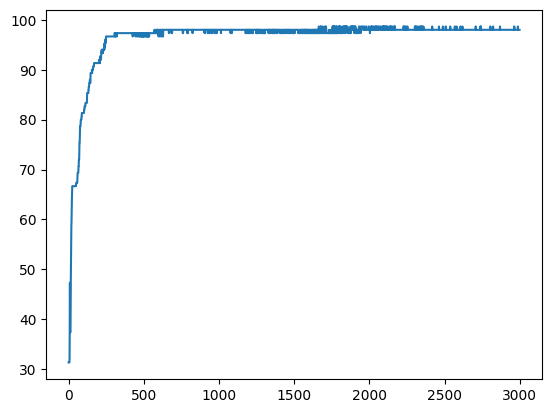

In [255]:
input_size = len(iris['data'][0])
output_size = len(np.unique(iris['target']))
hidden_size = 7
print(f"input size: {input_size}, hidden size: {hidden_size}, output size: {output_size}")

x = iris['data']
y = np.eye(output_size)[iris['target']]

network = NeuralNetwork(input_size, hidden_size, output_size)
epochs = 3000
learning_rate = 0.0001
loss, accuracy = network.train_mbgd(x, y, epochs, learning_rate, 20)
plt.plot(accuracy)